# Agrupando letras de Sambas

Letras de músicas segundo o vagalume.com.br, coletadas por Anderson Neisse e [disponíveis no kaggle](https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres/data).

Os dados originais foram tratados para diminuir duplicações e diminuir o tamanho do arquivo. Os resultados (e outros recortes dos dados de letras) estão [nesse repo](https://github.com/nazareno/palavras-nas-letras).


# Exercício:
Escolha um ou mais conjuntos de letras de músicas (diferentes do estilo já feito por Nazareno) e realize as etapas descritas a seguir:
1. Utilize o k-means para procurar grupos de músicas, identificando o melhor número de grupos através das técnicas explicadas nas aulas. Em seguida, descreva os grupos encontrados, listando as palavras e os artistas mais frequentes em cada grupo. Tente nomear os grupos e explique em detalhes o racional para sua nomeação para cada grupo. Repita este processo utilizando como entrada para o k-means:
- O título da música;
- A letra da música;
- A concatenação do título e letra;


# **Letra da Música**

In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [2]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
samba = pd.read_csv('https://github.com/nazareno/palavras-nas-letras/raw/master/letras-ptbr-samba-grande.csv')
sert = pd.read_csv('https://raw.githubusercontent.com/nazareno/palavras-nas-letras/master/letras-ptbr-sertanejo-grande.csv')
rock = pd.read_csv('https://raw.githubusercontent.com/nazareno/palavras-nas-letras/master/letras-ptbr-rock-grande.csv')

samba = samba[['SName', 'Lyric', 'Artist', 'Genre']]
rock = rock[['SName', 'Lyric', 'Artist', 'Genre']]
sert = sert[['SName', 'Lyric', 'Artist', 'Genre']]

musics = pd.concat([samba, rock, sert])
musics

SName  \
0                                                   1967   
1                                          Febre do Rato   
2                           À Procura da Batida Perfeita   
3                                               Desabafo   
4                                                Qual É?   
...                                                  ...   
15376  O Crime É o Crime / Dilma Sapatão / Instalar a...   
15377                                  Paixão Verdadeira   
15378                                      Pequeno Sábio   
15379                                      Tropa do Moço   
15380                                    Tropa do Moço 2   

                                                   Lyric      Artist  \
0      Nascido em São Cristóvão. Morador de Madureira...  Marcelo D2   
1      Não beijo pé do patrão. Não quero o que é dos ...  Marcelo D2   
2      À procura da batida perfeita. Então corre a ba...  Marcelo D2   
3      [Introdução]. Deixa,deixa,deixa. Eu dizer o qu...  Marcelo D2   
4      Ih, eu tenho algo a dizer. Explicar pra você. ...  Marcelo D2   
...                                                  ...         ...   
15376  O crime é o crime Bandido é Bandido. a guerra ...  Mc Vitinho   
15377  Garota Tôh aqui pra falar. quanto eu te amo. T...  Mc Vitinho   
15378  Eu sou pequeno mas a minha mente é grande. A s...  Mc Vitinho   
15379  Tu tá maluco vai mexer com uns cara desses. É ...  Mc Vitinho   
15380  Tropa do Moço 2. Tenha máximo respeito. E deix...  Mc Vitinho   

           Genre  
0          Samba  
1          Samba  
2          Samba  
3          Samba  
4          Samba  
...          ...  
15376  Sertanejo  
15377  Sertanejo  
15378  Sertanejo  
15379  Sertanejo  
15380  Sertanejo  

[31723 rows x 4 columns]

## Pré processamento do texto

In [4]:
stop_words = set(stopwords.words("portuguese"))
print(len(stop_words))

207


In [5]:
#construct a new list to store the cleaned text

def cleaner(df, column):
  clean_lyrics = []
  for w in range(len(df.Lyric)):
    
    lyric = df[column].values[w]
    #remove special characters and digits
    lyric = re.sub("(\\d|\\W)+|\w*\d\w*"," ", lyric)
    lyric = ' '.join(s for s in lyric.split() if (not any(c.isdigit() for c in s)) and len(s) > 2)
    clean_lyrics.append(lyric)
  return clean_lyrics

clean_lyrics = cleaner(musics, 'Lyric')

In [6]:
x = clean_lyrics
y = ['samba'] * samba.shape[0] + ['rock'] * rock.shape[0] + ['sert'] * sert.shape[0]

## Vetores TF-IDF

In [7]:
#TF-IDF vectorizer

def vectorizer(clean_lyrics):
  tfv = TfidfVectorizer(
          min_df = 10,
          max_df = 0.5,
          max_features = None,
          stop_words = stop_words,
          ngram_range = (1,3)
    )

  #transform
  vec_text = tfv.fit_transform(clean_lyrics)

  #returns a list of words.
  words = tfv.get_feature_names()
  return vec_text, words

vec_text, words = vectorizer(x)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Agrupamento

### Decidindo K

In [8]:
from sklearn.cluster import MiniBatchKMeans

# escolhendo k

def plot_k(vec_text):
  qualidade = pd.DataFrame(columns = ['k', 'ssd'])
  for k in range(1, 25, 1):
    # kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
    kmeans.fit(vec_text)
    qualidade = qualidade.append({'k': k, 'ssd' : kmeans.inertia_}, ignore_index=True)

  return alt.Chart(qualidade).mark_line(
             point=True
         ).encode(
             x = 'k',
             y = alt.Y('ssd', scale = alt.Scale(zero=False))
         )

plot_k(vec_text)

alt.Chart(...)

### Agrupando com o K escolhido

In [9]:
def training_kmeans(vec_text, k):
  kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
  # fit the data
  kmeans.fit(vec_text)
  labels = kmeans.predict(vec_text)
  musics_ag = musics.assign(grupo = labels)
  return musics_ag, kmeans

musics_ag, kmeans = training_kmeans(vec_text, 8)
musics_ag.sample(10)

SName  \
1108            O Que É O Amor?   
10114             Bem Sertanejo   
13945                    Vai Zé   
14288       Deus e Eu No Sertão   
14915             Pedaço de Mim   
7099   Minha Fã / A Mais de Cem   
13416                    Ara Pó   
1631                  Quem Será   
14961          Saudade Brejeira   
6991                   Lamentos   

                                                   Lyric  \
1108   O que é o amor?. Se perguntar o que é o amor p...   
10114  Toda vez que eu viajava pela estrada de Ouro F...   
13945  Vai, vai Zé no arrasta-pé. Vai, vai Zé no arra...   
14288  Nunca vi ninguém viver tão feliz. Como eu no s...   
14915  Minha vida tão mudada. Tão confusa, machucada....   
7099   Eu na Marginal no transito parado. Quando olhe...   
13416  Ara pó, ara pó. Ara pó, ara pó. É ponto de neg...   
1631   Escuta meu amor entenda de uma vez. Você tem q...   
14961  Que saudade do meu alazão. Do berrante imitand...   
6991   Morena, tem pena. Mas ouve o meu lamento. Tent...   

                          Artist      Genre  grupo  
1108                Arlindo Cruz      Samba      1  
10114                Michel Teló  Sertanejo      3  
13945            Tonico e Tinoco  Sertanejo      4  
14288               Victor e Leo  Sertanejo      0  
14915  Zezé Di Camargo e Luciano  Sertanejo      1  
7099                      Pixote      Samba      1  
13416   Tião Carreiro e Pardinho  Sertanejo      3  
1631                        Belo      Samba      2  
14961  Zezé Di Camargo e Luciano  Sertanejo      3  
6991                 Pixinguinha      Samba      1

## Interpretando os grupos

In [10]:
musics_ag['grupo'].value_counts()

3    10556
1     5718
2     5397
4     5380
0     2362
5     1089
7      803
6      418
Name: grupo, dtype: int64

In [11]:
#this loop transforms the numbers back into words

def print_common_words(kmeans):
  common_words = kmeans.cluster_centers_.argsort()[:,-1:-15:-1]
  for num, centroid in enumerate(common_words):
      print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

print_common_words(kmeans)

0 : vou, vai, hoje, amor, quero, fazer, sei, vou vou, ficar, vida, ver, agora, mim, tudo
1 : amor, coração, paixão, amar, faz, mim, vem, gente, assim, tudo, vida, tão, saudade, sei
2 : quero, mim, sei, tudo, ver, vou, pra mim, agora, assim, amor, aqui, coração, amo, tão
3 : deus, mundo, dia, mulher, todo, amor, vem, tudo, vida, nada, coração, senhor, ninguém, faz
4 : vai, vida, gente, tudo, bem, tempo, sempre, pode, dia, vou, sei, amor, faz, ter
5 : dois, maria, vezes, amor, serra, pedro, santa, santa maria, paulo mariano, pedro paulo mariano, maria serra, mariano, pedro paulo, paulo mariano santa
6 : vamos, gente, vamos fazer, tudo, vai, amor, fazer, vem, todos, bem, quero, dia, viver, então
7 : samba, viola, sambar, vem, roda, vai, povo, gente, vou, cantar, pagode, morro, mangueira, ver


Quais são algumas músicas do grupo X?

In [12]:
def find_by_group(musics_ag, group):
  pd.options.display.max_colwidth = 100
  query = "grupo == {group}".format(group = group)
  return musics_ag.query(query)[['SName', 'Lyric', 'Artist']].sample(10)

find_by_group(musics_ag, 4)

SName  \
6124   Por Essa Eu Não Esperava   
14648           Tapete Vermelho   
2802           Na Barba do Leão   
1331             Cidadão Padrão   
7150             Sigilo de Amor   
6056     Te Descartar É O Vício   
5792            Extremos Pueris   
10506         Seresteiro da Lua   
2910             Melhor Pra Mim   
4634         Comigo é Diferente   

                                                                                                     Lyric  \
6124   Por essa eu não esperava. Você com medo de ler com a luz apagada (uuu). Dizendo quando for velha...   
14648  Essa é a data que a gente preparou. 6 De fevereiro nosso casamento e nesse momento. Tô te espera...   
2802   Refrão:. Vai pagode vai pagode encher o mundo de beleza. Levando só alegria pra dar um tombo na ...   
1331   Almas vendidas,. você não quer nem saber.. Por tanta indiferença. não entendo sua omissão.. Mas ...   
7150   Toda vez que a gente marca chove. Surge de repente alguma prova. Dormiu mal ou esta sem tempo ho...   
6056   Se eu disser que sinto sua falta. Talvez eu me igualasse a você. Que acha que mentir pra si mesm...   
5792   O chão bifurcou. E o vento levou. Corações a gritar. Sem causa pra ter. Cegos, nem quisemos ver....   
10506  Abre janela. Oh! Querida. Venha ver o luar cor de prata. Venha ouvir o som deste meu pinho. Na c...   
2910   Olhando as estrelas. Nada no espaço. Fica parado no lugar. A terra se move. Os carros na estrada...   
4634   Você me abandonou pensando que ia sofrer. Está muito enganada pois não gosto de você. Tenho outr...   

                       Artist  
6124               Supercombo  
14648     Zé Neto e Cristiano  
2802                   Daniel  
1331                Dead Fish  
7150                   Pixote  
6056                   Strike  
5792                  Scalene  
10506  Milionário e José Rico  
2910                    Leoni  
4634        Gilberto e Gilmar

### Artistas mais presentes em cada grupo


In [13]:
musics_ag.query('grupo ==  {}'.format(1))

SName  \
16     Filho De Obá (part. Danilo Caymmi, Alice Caymmi & Rincon Sapiência)   
46                                                          Dor de Verdade   
47                                                      É Assim Que Se Faz   
65     Filho De Obá (part. Danilo Caymmi, Alice Caymmi & Rincon Sapiência)   
96                                                           Pra Que Amor?   
...                                                                    ...   
15027     Volta ao Começo (Quiero Beber Hasta Perder El Control) [Estúdio]   
15224                                      Amor Perfeito (Part. Duduzinho)   
15248                                      Amor Perfeito (Part. Duduzinho)   
15249                                          Amor Se Cura Com Outro Amor   
15377                                                    Paixão Verdadeira   

                                                                                                     Lyric  \
16     Eles falam em livre arbítrio. mas eu nunca tive escolha. nunca me mostraram um caminho ou me der...   
46     É. A procura da batida perfeita continua!. Meu samba é assim! Simbora!. Esse beat aqui oh!. Dá p...   
47     Ei pretinha!. Como é que cê tá?. "uhmm, Tô bem". Qual o seu nome heim?. Posso me sentar?. "Vou p...   
65     Eles falam em livre arbítrio. mas eu nunca tive escolha. nunca me mostraram um caminho ou me der...   
96     A-M-O-R... AMOOOOR! Eu disse A-M-O-R... AMOOOOR AMOOOOR!. Sem luz segura o flash eu tenho uma pe...   
...                                                                                                    ...   
15027  Todo caminho tem, tem ida e volta. Um coração alguém que já amou. Um campeão se mostra na derrot...   
15224  (Mc Marcelly). Depois de tantas lágrimas, decepções. Eu encontrei amor quando eu achei você. Foi...   
15248  (Mc Marcelly). Depois de tantas lágrimas, decepções. Eu encontrei amor quando eu achei você. Foi...   
15249  Eu não sei porque que você me deixou, nem teve coragem de vir me dizer. talvez por inveja do nos...   
15377  Garota Tôh aqui pra falar. quanto eu te amo. Te quero em minha vida. te desejo a todo estante. D...   

                          Artist      Genre  grupo  
16                    Marcelo D2      Samba      1  
46                    Marcelo D2      Samba      1  
47                    Marcelo D2      Samba      1  
65                    Marcelo D2      Samba      1  
96                    Marcelo D2      Samba      1  
...                          ...        ...    ...  
15027  Zezé Di Camargo e Luciano  Sertanejo      1  
15224                Mc Marcelly  Sertanejo      1  
15248                Mc Marcelly  Sertanejo      1  
15249                Mc Marcelly  Sertanejo      1  
15377                 Mc Vitinho  Sertanejo      1  

[5718 rows x 5 columns]

In [14]:
def print_groups(musics_agn, n_groups):
  for g in range(0, n_groups):
    print('\n-----\nGRUPO {}:'.format(g))
    print(musics_ag.query('grupo ==  {}'.format(g))[['Artist', 'Genre']].value_counts()[0:10])
    print('-----')

print_groups(musics_ag, 8)


-----
GRUPO 0:
Artist                Genre    
Luan Santana          Sertanejo    44
Gusttavo Lima         Sertanejo    37
Jota Quest            Rock         36
Gino & Geno           Sertanejo    32
Teodoro e Sampaio     Sertanejo    31
Raça Negra            Samba        30
Lulu Santos           Rock         30
Bruno e Marrone       Sertanejo    30
Gabriel Diniz         Sertanejo    29
Guilherme e Santiago  Sertanejo    29
dtype: int64
-----

-----
GRUPO 1:
Artist                     Genre    
Zezé Di Camargo e Luciano  Sertanejo    144
Belo                       Samba        116
Milionário e José Rico     Sertanejo    112
Paula Fernandes            Sertanejo    110
Chitãozinho e Xororó       Sertanejo     97
ExaltaSamba                Samba         94
Eduardo Costa              Sertanejo     91
Alcione                    Samba         91
Leonardo                   Sertanejo     89
Rick & Renner              Sertanejo     89
dtype: int64
-----

-----
GRUPO 2:
Artist                   

## Grupo 0: Sertanejo 
## Grupo 1: Sertanejo
## Grupo 2: Sertanejo
## Grupo 3: Rock/Samba
## Grupo 4: Rock
## Grupo 5: Sertanejo
## Grupo 6: Rock
## Grupo 7: Samba

In [15]:
musics_ag.query('Artist ==  "Raça Negra"')[['grupo', 'SName']].groupby('grupo').count()

SName
grupo       
0         30
1         88
2         96
3         27
4         16
5          1
6          2

## Visualizando grupos em muitas dimensões

Para visualizar melhor estruturas de semelhanças nos nossos dados, precisamos que eles estejam em 2D, usaremos um método de **redução de dimensionalidade**.

Os dois método mais frequentemente usados são PCA e t-SNE.

In [16]:
from sklearn.manifold import TSNE

# ESTOURO DE RAM
#musics_embedded = TSNE(n_components=2, verbose=1).fit_transform(vec_text)

In [17]:
def plot_groups(musics_ag, musics_embedded):
  musics_ag = musics_ag.assign(tsne1 = musics_embedded[:,0], tsne2 = musics_embedded[:,1])

  return alt.Chart(musics_ag.sample(1000)).mark_circle(
            opacity = .7,
            size = 30
         ).encode(
            x = 'tsne1',
            y = 'tsne2', 
            color = 'grupo:N',
            tooltip = ['Artist', 'SName']
  ).interactive()

#plot_groups(musics_ag, musics_embedded)

## Word Cloud

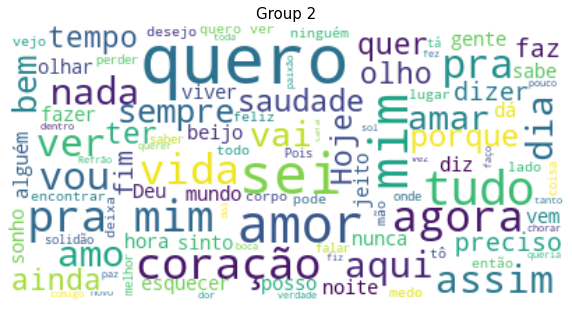

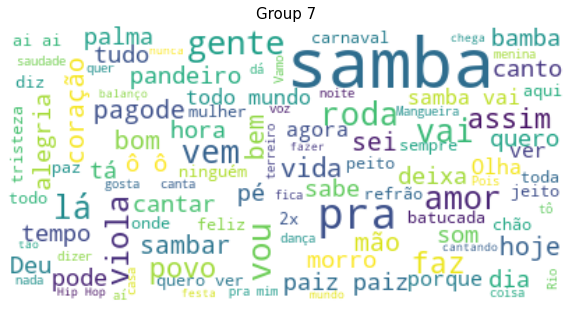

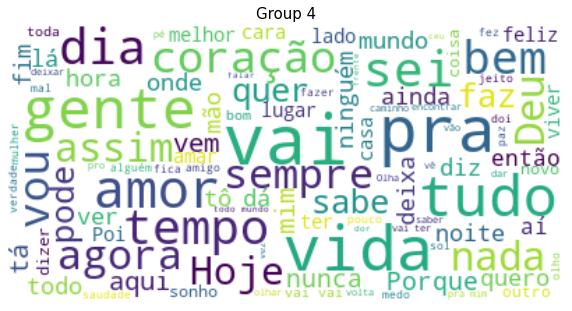

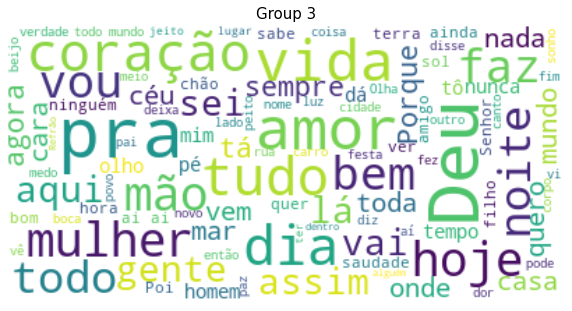

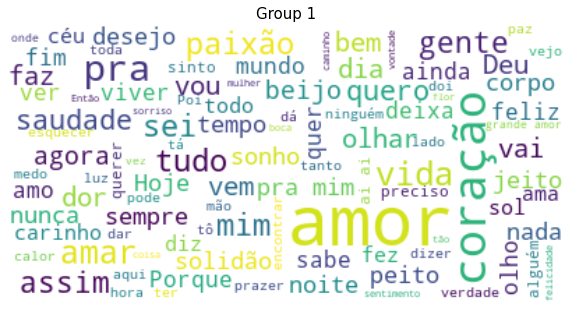

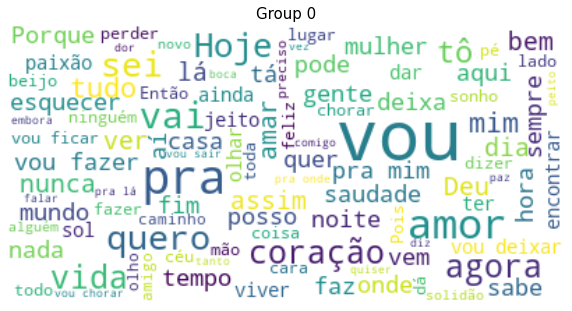

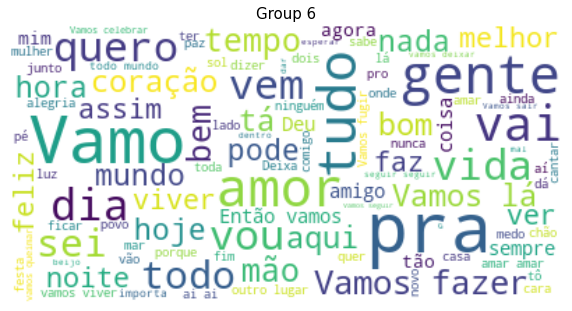

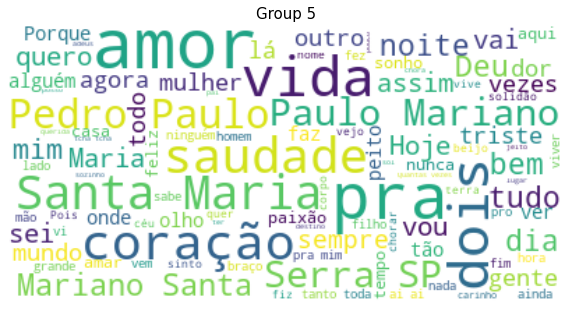

In [18]:
def word_cloud(musics_ag, column):
  for g in musics_ag['grupo'].unique():
    text = ""
    for lyric in musics_ag[column][musics_ag['grupo'] == g]:
      text += lyric  + " "
    wordcloud = WordCloud(stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Group ' + str(g), fontsize=15)
    plt.show()

word_cloud(musics_ag, 'Lyric')

# **Título da Música**

In [19]:
clean_lyrics = cleaner(musics, 'SName')
x = clean_lyrics
y = ['samba'] * samba.shape[0] + ['rock'] * rock.shape[0] + ['sert'] * sert.shape[0]

In [20]:
vec_text, words = vectorizer(x)
plot_k(vec_text)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


alt.Chart(...)

In [21]:
musics_ag, kmeans = training_kmeans(vec_text, 9)
musics_ag.sample(10)

SName  \
5471                             Vote Em Mim   
2306                           Cordas de Aço   
6534                               Combinado   
556                                Seu Padre   
3726   Fração de Segundo (part. Lulu Santos)   
7362                          Anjo da Guarda   
7873                            Gafieira S.a   
13811                               Canoeiro   
7788                            Homem Objeto   
2140                          Erramos Juntos   

                                                                                                     Lyric  \
5471   VOU SER PRESIDENTE DO SEU CORPO,. GOVERNAR,. ANARQUIZAR. MINHA PLATAFORMA É O PRAZER TOTAL. ISSO...   
2306   C7+ Ebo. Ah ! Estas cordas de aço. Dm7/G7. Este minúsculo braço. C Ebo Dm7 G7. Do violão que os ...   
6534   O combinado foi não cobrar nada,. Só viver momentos intensos de puro prazer. Eu fui sincero quan...   
556    Tava tudo planejado, os móveis. O buffet da festa e a lista de convidados. Comprei tudo do mais ...   
3726   O céu parece tão longe quando não há nada a dizer. Se você tem um problema então resolve com voc...   
7362   Não sei explicar como foi que aconteceu. O que já não brilhava em mim você acendeu. A chama do a...   
7873   É que eu fui dançar. E você não veio. O baile estava cheio. E eu não vi você chegar. Tentei te a...   
13811  Domingo de tardezinha eu estava meio a toa. Convidei uns companheiros pra ir pescar na lagoa. Le...   
7788   O mundo caiu sobre mim quando ela chegou e falou comigo. Me disse receba este beijo em seu rosto...   
2140   Se em sua vida eu não sou mais nada. Siga sua estrada, faça o que quiser. Mas fique sabendo, se ...   

                         Artist      Genre  grupo  
5471                   Rita Lee       Rock      2  
2306                    Cartola      Samba      5  
6534                  Mumuzinho      Samba      5  
556            Antony e Gabriel  Sertanejo      5  
3726                    Nx Zero       Rock      2  
7362             Jorge e Mateus  Sertanejo      0  
7873                  Seu Jorge      Samba      5  
13811           Tonico e Tinoco  Sertanejo      5  
7788   Léo Canhoto e Robertinho  Sertanejo      2  
2140           Chrystian e Ralf  Sertanejo      5

In [22]:
musics_ag['grupo'].value_counts()

5    13508
2     5742
0     5383
8     4655
1     1215
4      436
3      300
7      255
6      229
Name: grupo, dtype: int64

In [23]:
print_common_words(kmeans)

0 : vida, paixão, sol, flor, maria, fogo, canção, solidão, história, rei, vento, apaixonado, lua, onde
1 : amor, amor amor, história, paz, pra, assim, tudo, maior, sincero, gente, apenas, perfeito, mal, onde
2 : pra, part, vou, mim, samba, tudo, vai, mulher, quero, mundo, tempo, amar, dia, noite
3 : saudade, felicidade, pra, sinto, fez, terra, águas, amor, tereza, matar, passa, bate, samba, mandou
4 : coração, chora, fundo, cigano, bandido, dona, dono, cuida, pra, quer, pedaços, medida, simples, cowboy
5 : hora, aqui, amigo, brasil, felicidade, terra, lado, rua, alguém, morena, menina, cara, liga, novo
6 : nada, sonho, resto, ver, amor, louco, mudou, igual, fim, tudo, noite, mundo, além, caminhoneiro
7 : deus, quiser, livre, peço, eterno, quer, prova, falar, coisa, sabe, viola, amor, cuida, vai
8 : mar, rio, céu, ninguém, viola, chuva, olhos, jeito, luz, lágrimas, água, preciso, cabeça, boca


In [24]:
find_by_group(musics_ag, 4)

SName  \
5264                                           Coração de Fora   
8472                                      Meu Coração de Ferro   
11961                                           No Meu Coração   
7167   Tudo Por Você / Pode Me Ligar / Na Porta Do Seu Coração   
8007                                      Mistérios do Coração   
2345                                    Cabe Alguém no Coração   
8377                                       Cantinho do Coração   
758                                   Pra Machucar Meu Coração   
5859                                     A Dona do Meu Coração   
8391                                      Coração Em Desalinho   

                                                                                                     Lyric  \
5264   Não tenho cara de bobo. Se tô no jogo é pra ganhar. Eu não dou ponto sem nó. Ganho no gogó porqu...   
8472   Eu queria ser sincero ao meu amor. Eu queria ser sincero e não fingido. Eu queira dar pra ela um...   
11961  Existem tantos lugares. Pra onde eu posso ir. Mas somente um lugar. Onde eu desejo estar. No seu...   
7167   Fico te olhando, imaginando. Se eu pudesse te dizer tudo o que sinto por você. Te mudaria em rel...   
8007   Intro: E B7 E B7 C#m7 A7+ A/B C#m7 A7+ A/B. E. Só o tempo pra dizer. C#m7. O que vai acontecer. ...   
2345   Quando o amor acaba na metade do caminho. Quando o corpo pede mais um pouco de carinho. Quando n...   
8377   Se é verdade que tu vai embora. Eu não vou implorar compaixão. Se pretendes partir, vá agora. Eu...   
758    Está fazendo um ano e meio, amor. Que o nosso lar desmoronou. Meu sabiá, meu violão. E uma cruel...   
5859   Não sei se posso te encontrar de novo. Ainda e muito cedo pra poder te encarar. Meu corpo ainda ...   
8391   Numa estrada desta vida. Eu te conheci, oh flor. Vinhas tão desiludida. Mal sucedida por um fals...   

                     Artist  
5264   Guilherme e Santiago  
8472    Lourenço & Lourival  
11961   Rionegro & Solimões  
7167                 Pixote  
8007      Só Pra Contrariar  
2345      Cleiton e Camargo  
8377    Lourenço & Lourival  
758                 Alcione  
5859     Henrique e Juliano  
8391         Zeca Pagodinho

In [25]:
print_groups(musics_ag, 9)


-----
GRUPO 0:
Artist                       Genre    
Milionário e José Rico       Sertanejo    96
Tião Carreiro e Pardinho     Sertanejo    88
Lulu Santos                  Rock         86
Teodoro e Sampaio            Sertanejo    78
Paula Fernandes              Sertanejo    76
Zezé Di Camargo e Luciano    Sertanejo    71
Lourenço & Lourival          Sertanejo    69
Jota Quest                   Rock         66
Pedro Bento e Zé da Estrada  Sertanejo    65
Alcione                      Samba        62
dtype: int64
-----

-----
GRUPO 1:
Artist                     Genre    
Teodoro e Sampaio          Sertanejo    29
Zezé Di Camargo e Luciano  Sertanejo    24
Milionário e José Rico     Sertanejo    23
Paula Fernandes            Sertanejo    22
Belo                       Samba        21
Trio Parada Dura           Sertanejo    20
João Mineiro e Marciano    Sertanejo    19
Roberta Miranda            Sertanejo    18
Luan Santana               Sertanejo    18
Cezar & Paulinho           Sertanejo

## Grupo 0: Sertanejo
## Grupo 1: Sertanejo
## Grupo 2: Sertanejo
## Grupo 3: Sertanejo
## Grupo 4: Sertanejo
## Grupo 5: Rock/Samba
## Grupo 6: Sertanejo
## Grupo 7: Sertanejo
## Grupo 8: Sertanejo

In [27]:
musics_ag.query('Artist ==  "Raça Negra"')[['grupo', 'SName']].groupby('grupo').count()

SName
grupo       
0         31
1         14
2         80
3          2
4          3
5         73
6          1
7          3
8         53

In [30]:
# ESTOURO DE RAM
#musics_embedded = TSNE(n_components=2, verbose=1).fit_transform(vec_text)

In [31]:
#plot_groups(musics_ag, musics_embedded)

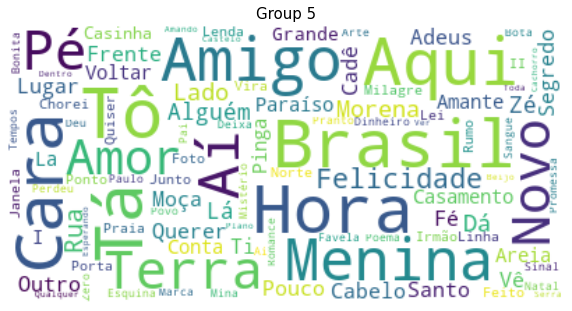

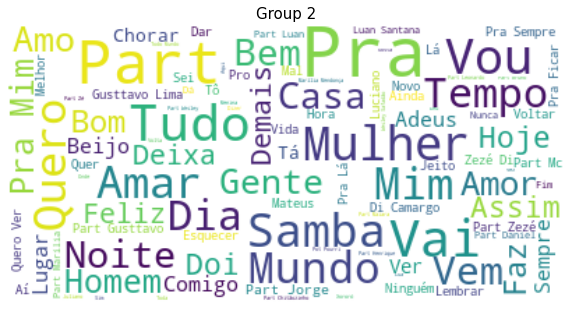

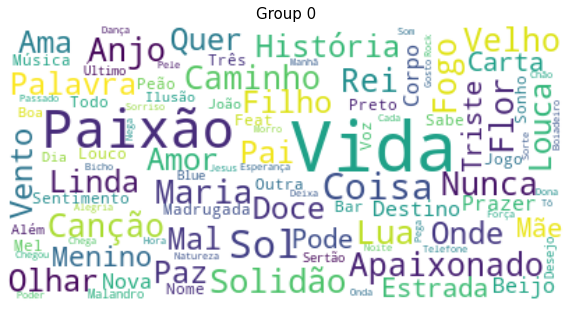

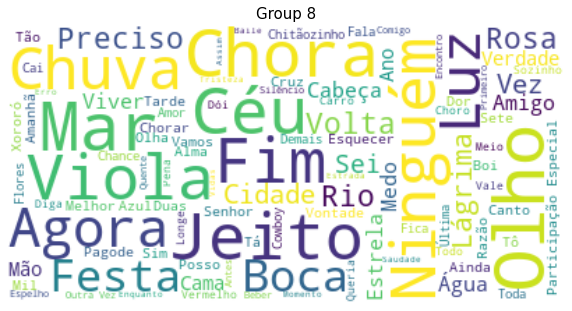

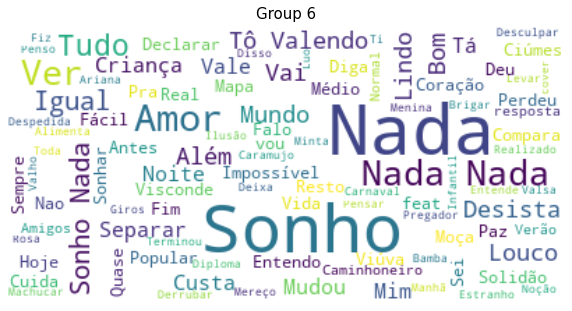

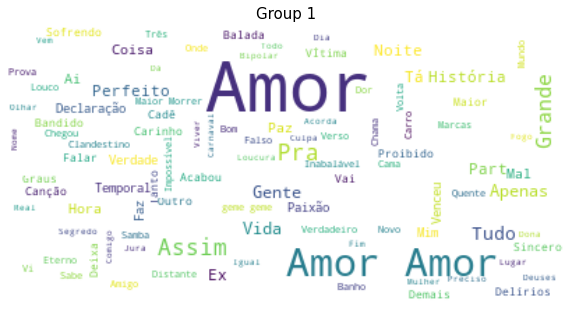

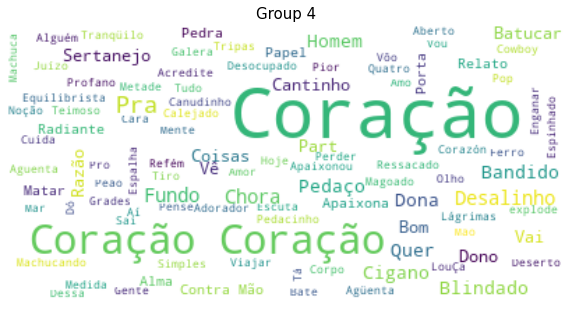

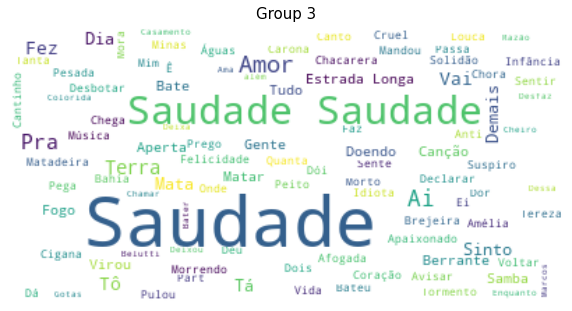

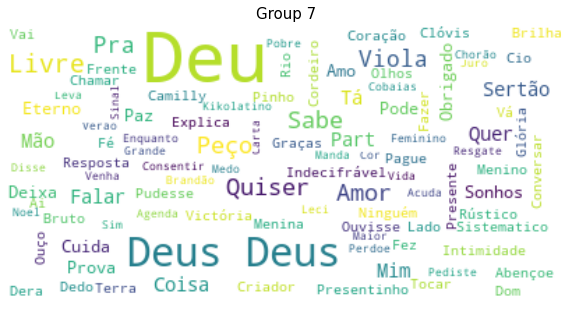

In [32]:
word_cloud(musics_ag, 'SName')

# **Título + Letra da Música**

In [35]:
musics['SL'] = musics['SName'] + " " + musics['Lyric']
musics.head()

SName  \
0                          1967   
1                 Febre do Rato   
2  À Procura da Batida Perfeita   
3                      Desabafo   
4                       Qual É?   

                                                                                                 Lyric  \
0  Nascido em São Cristóvão. Morador de Madureira. Desde pequeno acostumado a. subir ladeira. me le...   
1  Não beijo pé do patrão. Não quero o que é dos outros. Me ame, te estendo a mão. E a raiva fica p...   
2  À procura da batida perfeita. Então corre a batida é minha. Cheguei primeiro. No ruim faz a fezi...   
3  [Introdução]. Deixa,deixa,deixa. Eu dizer o que penso dessa vida. Preciso demais desabafar. [D2]...   
4  Ih, eu tenho algo a dizer. Explicar pra você. Mas não garanto porém que engraçado eu serei dessa...   

       Artist  Genre  \
0  Marcelo D2  Samba   
1  Marcelo D2  Samba   
2  Marcelo D2  Samba   
3  Marcelo D2  Samba   
4  Marcelo D2  Samba   

                                                                                                    SL  
0  1967 Nascido em São Cristóvão. Morador de Madureira. Desde pequeno acostumado a. subir ladeira. ...  
1  Febre do Rato Não beijo pé do patrão. Não quero o que é dos outros. Me ame, te estendo a mão. E ...  
2  À Procura da Batida Perfeita À procura da batida perfeita. Então corre a batida é minha. Cheguei...  
3  Desabafo [Introdução]. Deixa,deixa,deixa. Eu dizer o que penso dessa vida. Preciso demais desaba...  
4  Qual É? Ih, eu tenho algo a dizer. Explicar pra você. Mas não garanto porém que engraçado eu ser...

In [36]:
clean_lyrics = cleaner(musics, 'SL')
x = clean_lyrics
y = ['samba'] * samba.shape[0] + ['rock'] * rock.shape[0] + ['sert'] * sert.shape[0]

In [37]:
vec_text, words = vectorizer(x)
plot_k(vec_text)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


alt.Chart(...)

In [38]:
musics_ag, kmeans = training_kmeans(vec_text, 9)
musics_ag.sample(10)

SName  \
820            Não Tem Hora Pra Acabar   
5701                   Jeito de mulher   
6318              Quem São Os Animais?   
210                    Cheiro de Relva   
14034                Cerca De Espinhos   
4849                    Camisa Molhada   
5375                        Nave Terra   
3255   Caminhos do Mar (rainha do Mar)   
8481                     Faixa Amarela   
2641                             Papai   

                                                                                                     Lyric  \
820    Jogue os braços pra cima. Bata na palma da mão. Transmita a energia que motiva o peão. O show ta...   
5701   Seu jeito de menina apaixonada. É tudo que preciso pra viver. Confesso que és o chão da minha es...   
6318   Te julgam e não aceitam a tua fome. Te insultam e te condenam a pecar. Te julgam e nem conhecem ...   
210    Como é bonito estender-se no verão. As cortinas do sertão na varanda das manhãs. Deixar entrar p...   
14034  Parece que tem uma cerca de espinhos. Esse caminho entre eu e você. E bem pior que arame farpado...   
4849   Nesta madrugada vou seguir viagem. Já comprei passagem, ficar não tem jeito. A mala está cheia d...   
5375   Nave Terra, cheia de natureza. O Sol é convosco. Bendita sois vós entre os Planetas. E Bendito é...   
3255   Rainha do mar. Yemanja Odoiá Odoiá. Rainha do mar. O canto vinha de longe. De la do meio do mar....   
8481   Eu quero presentear. A minha linda donzela. Não é prata nem é ouro. É uma coisa bem singela. Vou...   
2641   Eeh! papai, eu aprendi certinho viu?. Papai to aqui na cama. Hoje da Amanda amanha da Juliana. P...   

                 Artist      Genre  \
820    Bruno e Barretto  Sertanejo   
5701         Katinguelê      Samba   
6318              Titãs       Rock   
210     Paula Fernandes  Sertanejo   
14034  Trio Parada Dura  Sertanejo   
4849        Gino & Geno  Sertanejo   
5375           Rita Lee       Rock   
3255     Dorival Caymmi      Samba   
8481     Zeca Pagodinho      Samba   
2641   Cristiano Araújo  Sertanejo   

                                                                                                        SL  \
820    Não Tem Hora Pra Acabar Jogue os braços pra cima. Bata na palma da mão. Transmita a energia que ...   
5701   Jeito de mulher Seu jeito de menina apaixonada. É tudo que preciso pra viver. Confesso que és o ...   
6318   Quem São Os Animais? Te julgam e não aceitam a tua fome. Te insultam e te condenam a pecar. Te j...   
210    Cheiro de Relva Como é bonito estender-se no verão. As cortinas do sertão na varanda das manhãs....   
14034  Cerca De Espinhos Parece que tem uma cerca de espinhos. Esse caminho entre eu e você. E bem pior...   
4849   Camisa Molhada Nesta madrugada vou seguir viagem. Já comprei passagem, ficar não tem jeito. A ma...   
5375   Nave Terra Nave Terra, cheia de natureza. O Sol é convosco. Bendita sois vós entre os Planetas. ...   
3255   Caminhos do Mar (rainha do Mar) Rainha do mar. Yemanja Odoiá Odoiá. Rainha do mar. O canto vinha...   
8481   Faixa Amarela Eu quero presentear. A minha linda donzela. Não é prata nem é ouro. É uma coisa be...   
2641   Papai Eeh! papai, eu aprendi certinho viu?. Papai to aqui na cama. Hoje da Amanda amanha da Juli...   

       grupo  
820        3  
5701       1  
6318       3  
210        4  
14034      8  
4849       4  
5375       5  
3255       4  
8481       6  
2641       1

In [39]:
musics_ag['grupo'].value_counts()

3    6744
4    6603
2    4011
8    3030
1    2587
7    2539
6    2462
0    1983
5    1764
Name: grupo, dtype: int64

In [40]:
print_common_words(kmeans)

0 : quero, amar, amor, ver, quero ver, vou, mim, vida, coração, vem, viver, bem, sei, preciso
1 : mulher, cara, casa, homem, amigo, agora, quer, todo, dia, gente, aqui, vida, vai, noite
2 : amor, gente, coração, paixão, faz, amar, vai, vem, amor amor, sei, assim, vida, bem, mim
3 : vai, samba, vem, gente, pode, vou, quer, deixa, ver, bem, faz, pro, todo, bom
4 : vida, saudade, coração, tão, dia, amor, tempo, sempre, mundo, bem, nunca, noite, hoje, onde
5 : deus, senhor, jesus, terra, filho, onde, amor, vida, pai, vai, céu, dia, mundo, aqui
6 : vou, vai, amor, sei, quero, mim, hoje, fazer, ficar, vida, chorar, ver, coração, vou vou
7 : tudo, nada, amor, tempo, bem, sei, gente, faz, vai, mundo, dia, sempre, aqui, mim
8 : mim, pra mim, assim, sei, amo, amor, coração, vai, diz, faz, dizer, quer, sabe, agora


In [41]:
find_by_group(musics_ag, 4)

SName  \
5703                   Falsos Oásis   
6987         A Revolta dos Dândis I   
11822           A Saudade é O Prego   
4070                         Sonhos   
2661                       Star Man   
2759   Ainda É Cedo / Gimme Shelter   
2874                Sonho Encantado   
1832         Obrigada, Pelas Flores   
355            Vale do Rio Vermelho   
4678           Homenagem à Mãezinha   

                                                                                                     Lyric  \
5703   No rosto do Brasil. As rugas de quem viu. Nas ruas toda a miséria. Nas duas faces da história. s...   
6987   Entre um rosto e um retrato. O real e o abstrato. Entre a loucura e a lucidez. Entre o uniforme ...   
11822  Deu um arrocho no peito. Eu fiquei apavorado. São Paulo ficou pequena. Um lugarzinho abafado. Pe...   
4070   O vento toca o meu rosto. Me lembrando que o tempo vai com ele. Levando em suas asas os meus dia...   
2661   Eu não vim aqui pra delirar. Neste lugar eu sou antena. Auto-falante, eu vejo tudo. Eu só vim aq...   
2759   Uma menina me ensinou. Quase tudo que eu sei. Era quase escravidão. Mas ela me tratava como um r...   
2874   Eu nasci, cresci ouvindo a tua voz. Pelo rádio ou num programa de TV. Sonhava acordado em te con...   
1832   Obrigada pelas rosas que me deste amor. eu te agradeço com ternura e fervor. não me esqueci, nem...   
355    Se você meu amor vai embora. Vai também com você a alegria. E o vaqueiro que muito te adora. Sem...   
4678   Oh senhora, que está nos ouvindo. Pelo rádio, em gravação. Dedicamos esta melodia. Como prova da...   

                      Artist  
5703                     RPM  
6987   Engenheiros do Hawaii  
11822    Rionegro & Solimões  
4070              Oficina G3  
2661              Jota Quest  
2759           Legião Urbana  
2874                  Daniel  
1832           Beth Carvalho  
355          Paula Fernandes  
4678       Gilberto e Gilmar

In [42]:
print_groups(musics_ag, 9)


-----
GRUPO 0:
Artist                     Genre    
Paula Fernandes            Sertanejo    42
Zezé Di Camargo e Luciano  Sertanejo    35
Katinguelê                 Samba        33
Lulu Santos                Rock         30
Bruno e Marrone            Sertanejo    30
Belo                       Samba        28
Rick & Renner              Sertanejo    26
Raça Negra                 Samba        25
Marcos e Fernando          Sertanejo    25
Alcione                    Samba        25
dtype: int64
-----

-----
GRUPO 1:
Artist                    Genre    
Teodoro e Sampaio         Sertanejo    164
Bezerra da Silva          Samba         76
Tião Carreiro e Pardinho  Sertanejo     64
Gino & Geno               Sertanejo     64
Velhas Virgens            Rock          59
Guilherme e Santiago      Sertanejo     47
Léo Canhoto e Robertinho  Sertanejo     43
Chico Buarque             Samba         39
Lourenço & Lourival       Sertanejo     39
Trio Parada Dura          Sertanejo     38
dtype: int64
---

### Grupo 0: Sertanejo
### Grupo 1: Sertanejo
### Grupo 2: Sertanejo
### Grupo 3: Samba
### Grupo 4: Sertanejo
### Grupo 5: Sertanejo
### Grupo 6: Sertanejo
### Grupo 7: Rock
### Grupo 8: Sertanejo

In [43]:
musics_ag.query('Artist ==  "Raça Negra"')[['grupo', 'SName']].groupby('grupo').count()

SName
grupo       
0         25
1          1
2         62
3         21
4         30
5          6
6         31
7         13
8         71

In [44]:
# ESTOURO DE RAM
#musics_embedded = TSNE(n_components=2, verbose=1).fit_transform(vec_text)

In [45]:
#plot_groups(musics_ag, musics_embedded)

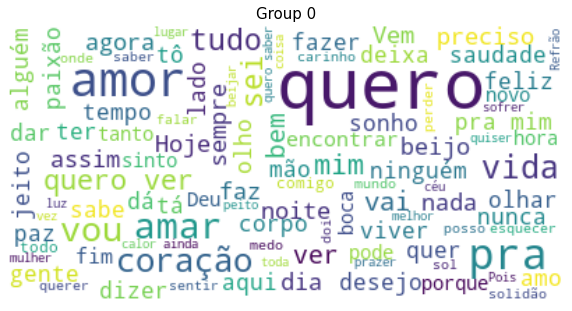

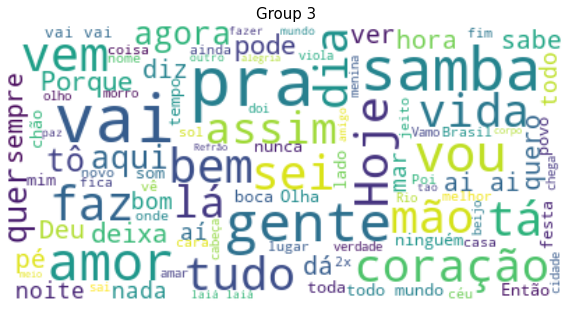

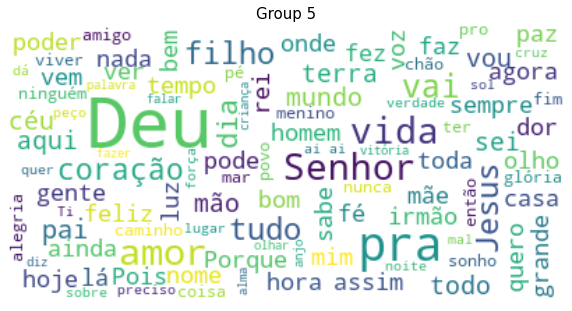

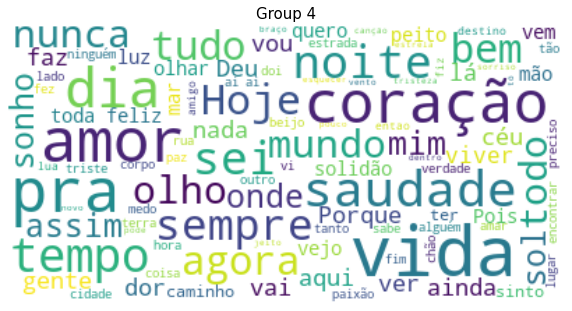

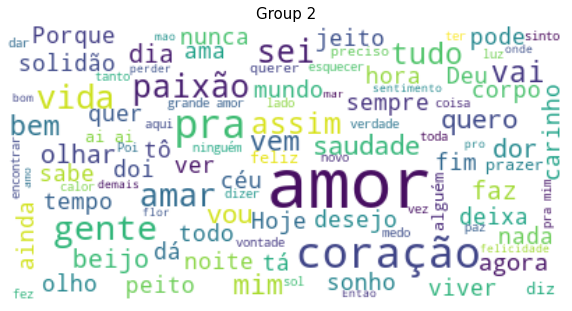

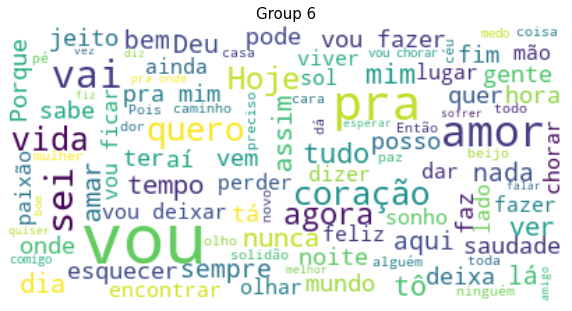

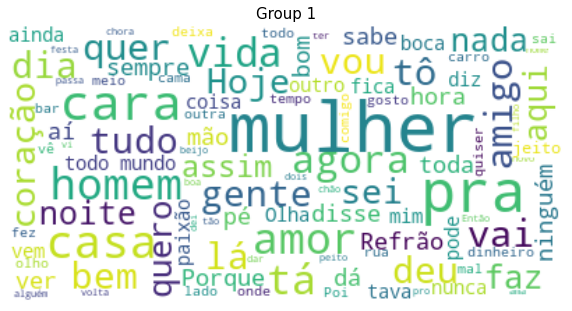

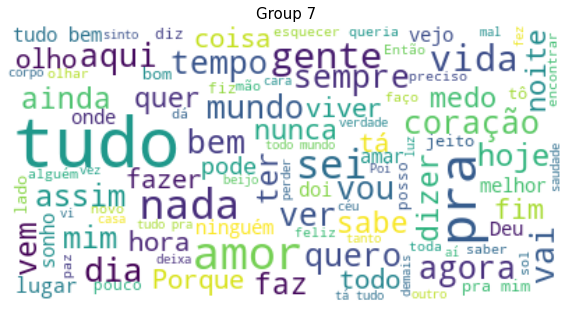

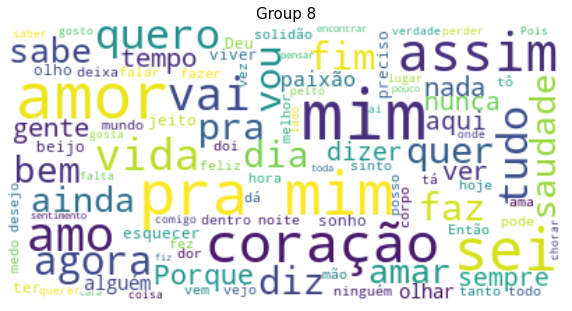

In [46]:
word_cloud(musics_ag, 'SL')